<a href="https://colab.research.google.com/github/MaxTheMooshroom/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture

# Install packages in Colab
!pip install category_encoders==2.*
!pip install eli5
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

_train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert _train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [5]:
_train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [6]:
print(_train.columns.to_list())

['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type', 'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date', 'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location', 'Fail']


In [0]:
target = 'Fail'
features = ['DBA Name', 'Facility Type', 'Risk', 'Inspection Type', 'Violations', 'Zip']

In [8]:
_train['Inspection Date'].value_counts()

2017-03-23T00:00:00    50
2010-06-07T00:00:00    49
2016-05-26T00:00:00    46
2017-06-08T00:00:00    46
2017-03-31T00:00:00    46
                       ..
2011-08-20T00:00:00     1
2017-03-13T00:00:00     1
2010-12-18T00:00:00     1
2010-02-06T00:00:00     1
2015-08-03T00:00:00     1
Name: Inspection Date, Length: 2257, dtype: int64

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

###Fit a model with the train set.

In [0]:
from sklearn.model_selection import train_test_split, cross_val_score

In [10]:
train, validate = train_test_split(_train)
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
12628,1300963,PETE'S FRESH MARKET,PETE'S FRESH MARKET,1598145.0,Grocery Store,Risk 1 (High),3448 E 118TH ST,CHICAGO,IL,60617.0,2012-12-18T00:00:00,Suspected Food Poisoning Re-inspection,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.681060,-87.539368,"{'longitude': '-87.53936754137594', 'latitude'...",0
30705,1099018,MULLIGAN'S,MULLIGAN'S,2252285.0,Restaurant,Risk 2 (Medium),5155 N LINCOLN AVE,CHICAGO,IL,60625.0,2013-06-06T00:00:00,License,NaN,41.975663,-87.692195,"{'longitude': '-87.6921953815788', 'latitude':...",0
9325,1584187,THE FIREPLACE INN,THE FIREPLACE INN,2424149.0,Restaurant,Risk 1 (High),1448-1450 N WELLS ST,CHICAGO,IL,60610.0,2015-11-10T00:00:00,License,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.908978,-87.634789,"{'longitude': '-87.63478912164865', 'latitude'...",0
50728,2129355,CAMPBELL'S JERK,CAMPBELL'S JERK,2528557.0,Restaurant,Risk 1 (High),412 E 87TH ST,CHICAGO,IL,60619.0,2017-12-18T00:00:00,Complaint Re-Inspection,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.736622,-87.613934,"{'longitude': '-87.61393435409144', 'latitude'...",0
15817,1154798,SKY LAKE CHINESE KITCHEN,SKY LAKE CHINESE KITCHEN,1980111.0,Restaurant,Risk 1 (High),2 W 103RD ST,CHICAGO,IL,60628.0,2013-01-10T00:00:00,Canvass,"26. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, P...",41.707274,-87.623586,"{'longitude': '-87.62358592336454', 'latitude'...",1


In [0]:
X_train = train[features]
y_train = train[target]

X_validate = validate[features]
y_validate = validate[target]

X_test = test[features]
y_test = test[target]

In [0]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn

In [0]:
transformers = make_pipeline(
  ce.OrdinalEncoder(),
  SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
)

In [65]:
X_train_trans = pd.DataFrame(transformers.fit_transform(X_train, y_train), index=X_train.index, columns=X_train.columns)
X_validate_trans = pd.DataFrame(transformers.transform(X_validate), index=X_validate.index, columns=X_train_trans.columns)

model = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=2)
model.fit(X_train_trans, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

###Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

In [79]:
probas = model.predict_proba(X_validate_trans)[:,-1]
y_pred = model.predict(X_validate_trans)

roc_auc_score(y_validate, probas)

0.6270043130394819

In [80]:
scores = cross_val_score(model, X_train_trans, y_train, cv=15, scoring='roc_auc')
scores.mean()

0.6870778182892509

## Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- [X] Permutation Importances
- [X] Partial Dependence Plot, 1 feature isolation
- [X] Partial Dependence Plot, 2 features interaction
- [ ] Shapley Values

### Permutation Importances

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

In [0]:
perm = PermutationImportance(model, random_state=42)
perm.fit(X_train_trans, y_train);

In [71]:
eli5.show_weights(perm, feature_names=X_train_trans.columns.str.replace(' ', '_').to_list())

Weight,Feature
0.0152 ± 0.0014,Inspection_Type
0.0099 ± 0.0006,Violations
0.0059 ± 0.0008,Risk
0.0037 ± 0.0006,Facility_Type
0.0036 ± 0.0011,Zip
0.0029 ± 0.0003,DBA_Name


###Partial Feature Dependence: Isolation

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import matplotlib.pyplot as plt

In [83]:
X_validate_trans.columns

Index(['DBA Name', 'Facility Type', 'Risk', 'Inspection Type', 'Violations',
       'Zip'],
      dtype='object')

In [84]:
feature_isolate = 'Inspection Type'
print(X_validate_trans[feature_isolate].nunique())
X_validate_trans[feature_isolate].value_counts().sort_index()

25


-2.0        1
-1.0        9
 1.0       16
 2.0     1983
 3.0      581
 4.0     6023
 5.0     1627
 6.0     1216
 7.0       49
 8.0      475
 9.0       51
 10.0     736
 11.0      48
 12.0      57
 13.0      24
 15.0      33
 16.0       8
 17.0      16
 18.0       7
 19.0       6
 20.0       2
 21.0       5
 23.0       1
 26.0       1
 28.0       4
Name: Inspection Type, dtype: int64

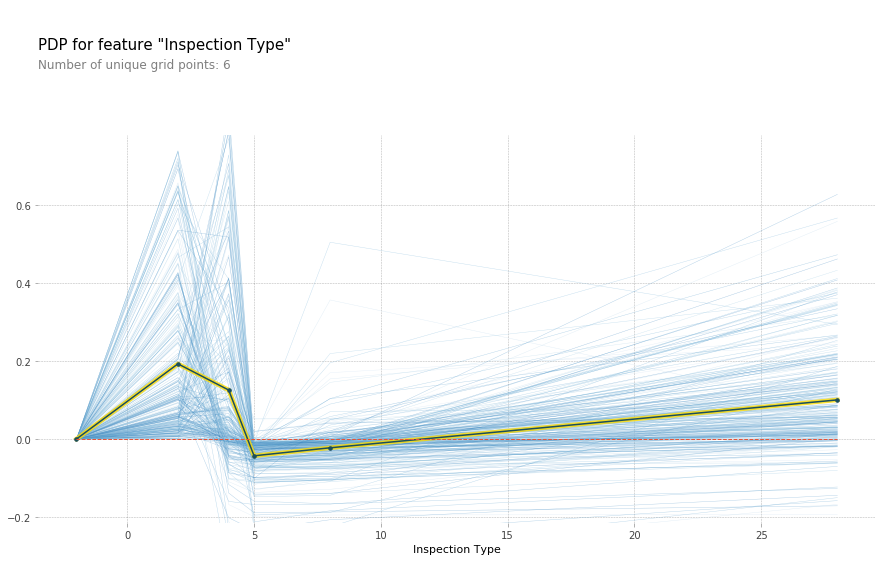

In [85]:
isolator = pdp_isolate(
    model=boost,
    dataset=X_validate_trans,
    model_features=X_validate_trans.columns,
    feature=feature_isolate
)

pdp_plot(isolator, feature_name=feature_isolate, plot_lines=True, frac_to_plot=300); # plotted extra lines to see some variation

###Partial Feature Dependence: Interaction

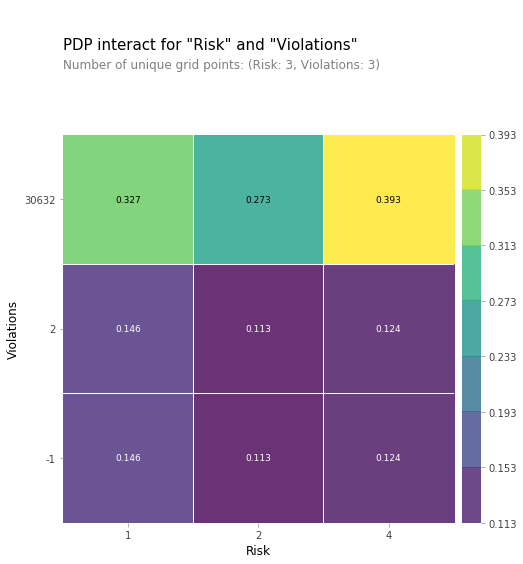

In [87]:
features_isolate = ['Risk', 'Violations']

interactor = pdp_interact(
    boost, 
    X_validate_trans, 
    X_validate_trans.columns, 
    features_isolate
)

pdp_interact_plot(interactor, features_isolate, plot_type='grid');